In [22]:
import TechCore.Simulator.simulator_optimized as simulator

from TechCore.Strategies import Future, Midprice, Stoikov

import TechCore.Simulator.get_info as get_info
import TechCore.Simulator.load_data as load_data

from importlib import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path_to_file = '../TechCore/data/md/btcusdt_Binance_LinearPerpetual/'

In [23]:
run_time = pd.Timedelta(10, 'm').delta
md = load_data.load_md_from_file(path=path_to_file, run_time=run_time)

In [24]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta
delay = pd.Timedelta(0.1, 's').delta

In [25]:
reload(simulator)

reload(Future)
reload(Midprice)
reload(Stoikov)

reload(get_info)
reload(load_data)

<module 'TechCore.Simulator.load_data' from 'C:\\Users\\artem\\.Computer Science\\CMF\\Projects\\High_Frequency_Market_Making\\TechCore\\Simulator\\load_data.py'>

In [26]:
def run_stoikov(gamma):
    reload(simulator)
    reload(Stoikov)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Stoikov.Strategy(
        delay=delay,
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [27]:
def run_future(gamma):
    reload(simulator)
    reload(Future)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Future.Strategy(
        delay=delay,
        future_timestamp=10**9, #ns
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [28]:
def run_midprice(gamma):
    reload(simulator)
    reload(Midprice)
    reload(get_info)
    reload(load_data)

    sim = simulator.SimOptim(md, latency, md_latency)

    strat = Midprice.Strategy(
        delay=delay,
        risk_koef=gamma,
        time_oi=60*10**9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=25,
        min_asset_value=0.001,
        volatility_record_cooldown=0.1*10**9, #ns
        volatility_horizon=1000,
        order_intensity_min_samples=100
    )
    strat.run(sim)
    return strat.logs

In [29]:
future_logs = run_future(1)
midprice_logs = run_midprice(1)
stoikov_logs = run_stoikov(1)

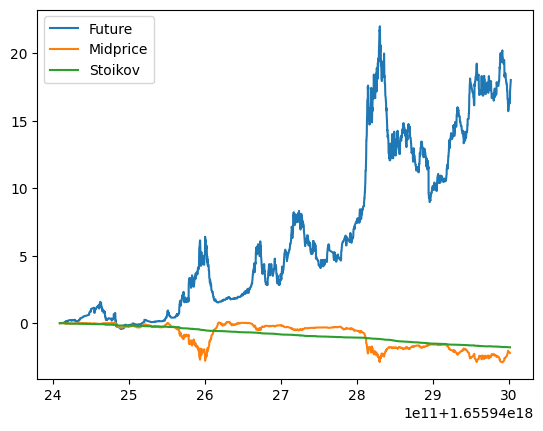

In [35]:
plt.plot(future_logs['own_trade_time'], future_logs['pnl'], label='Future')
plt.plot(midprice_logs['own_trade_time'], midprice_logs['pnl'], label='Midprice')
plt.plot(stoikov_logs['own_trade_time'], stoikov_logs['pnl'], label='Stoikov')
plt.legend()
plt.show()